Analysis for generating cartodb visualizations of pollution data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
from datetime import datetime
import re
from datetime import timedelta
from sklearn.cluster import KMeans

In [2]:
def change_hour(s):
    if '24:00' in s:
        current_day = re.findall(r'(\d{4}-\d{2}-\d{2})\s\d{2}:\d{2}', s)[0]
        current_day = datetime.strptime(current_day, '%Y-%m-%d')
        next_day = current_day + timedelta(days=1)
        return datetime.strftime(next_day, '%Y-%m-%d %H:%M')
    else:
        return s
    
def count_bad(measurements):
    count = 0.0
    for m in measurements:
        count += float(m >= 96)
    return count

def get_day(dt):
    return datetime.strftime(dt, "%Y-%m-%d")

def get_time(dt):
    return datetime.strftime(dt, "%H:%M:%S")

def categorize(x):
    return int(x / 14)

def get_week_days(dt):
    days = []
    for i in range(7):
        d = dt - timedelta(days=i)
        days.append(datetime.strftime(d, "%Y-%m-%d"))
    return days

def set_timezone(dt):
    date_time = dt.to_datetime()

In [3]:
pal = sns.color_palette("RdYlGn", 10)
colors = pal.as_hex()
colors.reverse()

In [48]:
# Read in the catalogue of stations and make a dictionary of stations codes to latitude and longitude
stations = pd.read_csv('data/raw/cat_estacion.csv', skiprows=1, encoding='latin1')
stations = stations[['cve_estac', 'longitud', 'latitud']].sort_values(by='cve_estac')
station_coords = {}
for index, row in stations.iterrows():
    station_coords[row['cve_estac']] = {'lat': row['latitud'], 'lon': row['longitud']}

In [49]:
# Read in the 2016 data and fill blanks
aq_16 = pd.read_json('data/cleaned/contaminantes_2016_sm_O3.json').sort_values(by='date')
aq_16 = aq_16.replace('', np.nan)

In [50]:
# Convert the date columns
aq_16['date'] = aq_16['date'].apply(change_hour)
aq_16['date'] = pd.to_datetime(aq_16['date'])

# Convert other columns to numeric datatype
cols = aq_16.columns.tolist()
cols.remove('date')
aq_16[cols] = aq_16[cols].apply(pd.to_numeric)

# Calculate the mean and total count of bad readings per hour
aq_16['all_mean'] = aq_16[cols].mean(axis=1)
aq_16['bad_count'] = aq_16[cols].apply(lambda r: count_bad(r), axis=1)

In [51]:
aq_16['null_count'] = aq_16[cols].isnull().sum(axis=1)
# Extract other representations of date and time
aq_16['time'] = aq_16['date'].apply(lambda x: get_time(x))
aq_16['day'] = aq_16['date'].apply(lambda x: get_day(x))

In [52]:
# Find the stations that were used in 2016
stations_16 = stations[stations['cve_estac'].isin(cols)].copy()

In [53]:
# Cluster the stations together, into 9 clusters

X = np.array(stations_16[['longitud', 'latitud']])

kmeans = KMeans(n_clusters=9).fit(X)
stations_16['cluster'] = (kmeans.labels_)
stations_16 = stations_16.sort_values('cluster')

In [54]:
# Look first at the aggregate readings across the city
aggregate = aq_16[['date', 'all_mean', 'bad_count', 'null_count', 'time', 'day']].copy()
aggregate.index = aggregate['date']
aggregate = aggregate.drop('date', axis=1)

In [55]:
# Week with maximum number of bad readings
aggregate['bad_count'].resample('W').sum().sort_values(ascending=False).index[0]

Timestamp('2016-04-10 00:00:00')

In [56]:
# Week with lowest mean
aggregate['all_mean'].resample('W').mean().sort_values(ascending=True).index[0]

Timestamp('2016-10-02 00:00:00')

#### Start with the worst week

In [57]:
# Get dates of all days in the week
max_day = datetime(2016,4,10)
max_week = get_week_days(max_day)

In [35]:
# Average over week, and use interpolation to go from hours to minutes

clusters = {}

for i in range(9):
    stat = stations_16[stations_16['cluster'] == i]['cve_estac'].unique().tolist()
    sub = aq_16[stat + ['date', 'time', 'day']]
    sub = sub[sub['day'].isin(max_week)]
    sub = sub.groupby('time')[stat].mean()
    sub.reset_index(inplace=True)
    clusters[i] = sub
    
df = clusters[0].merge(clusters[1])
for i in range(2, 9):
    df = df.merge(clusters[i])
    
df = df.dropna(how='all', axis=1).copy()

df.index=pd.date_range("2016-04-04 00:00", "2016-04-04 23:59", freq="60min")
df.drop('time', inplace=True, axis=1)

df = df.reindex(index=pd.date_range("2016-04-04 00:00", "2016-04-04 23:59", freq="1min"))
df = df.interpolate(method='time')
df.reset_index(inplace=True)

In [38]:
cols = df.columns.tolist()
cols.remove('index')

max_vals = pd.DataFrame(index = [], columns=['value', 'time'])

for c in cols:
    d = df[[c, 'index']].copy()
    d['station'] = c
    d.columns = [['value', 'time', 'station']]
    max_vals = max_vals.append(d)
    
max_vals['latitud'] = max_vals['station'].apply(lambda x: station_coords[x]['lat'])
max_vals['longitud'] = max_vals['station'].apply(lambda x: station_coords[x]['lon'])
max_vals['time'] = max_vals['time'].apply(lambda x: x.tz_localize('America/Mexico_City'))

In [222]:
max_cat = max_vals.copy()
max_cat['value'] = max_cat['value'].apply(categorize)
max_cat.drop('station', axis=1).to_csv("max_day.csv", index=None)

In [77]:
#Worst hour
max_hour = max_vals.groupby(max_vals['time'].dt.hour)['value'].mean().sort_values(ascending=False).index[0]
max_vals['hour'] = max_vals['time'].dt.hour
max_day_peak = max_vals[max_vals['hour'] == max_hour][['time', 'value', 'latitud', 'longitud']]
max_day_peak = peak[peak['time'] == '2016-04-04 15:00:00-05:00']

#### Repeat analysis for best week

In [70]:
# Get dates of all days in the week
min_day = datetime(2016,10,2)
min_week = get_week_days(min_day)

In [60]:
# Average over week, and use interpolation to go from hours to minutes

clusters = {}

for i in range(9):
    stat = stations_16[stations_16['cluster'] == i]['cve_estac'].unique().tolist()
    sub = aq_16[stat + ['date', 'time', 'day']]
    sub = sub[sub['day'].isin(min_week)]
    sub = sub.groupby('time')[stat].mean()
    sub.reset_index(inplace=True)
    clusters[i] = sub
    
df = clusters[0].merge(clusters[1])
for i in range(2, 9):
    df = df.merge(clusters[i])
    
df = df.dropna(how='all', axis=1).copy()

df.index=pd.date_range("2016-09-26 00:00", "2016-09-26 23:59", freq="60min")
df.drop('time', inplace=True, axis=1)

df = df.reindex(index=pd.date_range("2016-09-26 00:00", "2016-09-26 23:59", freq="1min"))
df = df.interpolate(method='time')
df.reset_index(inplace=True)

In [61]:
cols = df.columns.tolist()
cols.remove('index')

min_vals = pd.DataFrame(index = [], columns=['value', 'time'])

for c in cols:
    d = df[[c, 'index']].copy()
    d['station'] = c
    d.columns = [['value', 'time', 'station']]
    min_vals = min_vals.append(d)
    
min_vals['latitud'] = min_vals['station'].apply(lambda x: station_coords[x]['lat'])
min_vals['longitud'] = min_vals['station'].apply(lambda x: station_coords[x]['lon'])
min_vals['time'] = min_vals['time'].apply(lambda x: x.tz_localize('America/Mexico_City'))

In [81]:
#Worst hour
max_hour = min_vals.groupby(min_vals['time'].dt.hour)['value'].mean().sort_values(ascending=False).index[0]
min_vals['hour'] = min_vals['time'].dt.hour
min_day_peak = min_vals[min_vals['hour'] == max_hour][['time', 'value', 'latitud', 'longitud']]
min_day_peak = min_day_peak[min_day_peak['time'] == '2016-09-26 14:00:00-05:00']

In [62]:
### Combine Min and Max vals

In [66]:
vals = min_vals.append(max_vals)
vals['value'] = vals['value'].apply(categorize)

In [67]:
vals.drop('station', axis=1).to_csv("pollution_dynamic.csv", index=None)

In [78]:
### Combine peak values

In [86]:
peaks = max_day_peak.append(min_day_peak)
peaks.to_csv('peak_hours.csv', index=False)

#### Generate css and legend for CartoDB

In [132]:
css = []
for i in range(10):
    s = "#pollution_dynamic[value={}] {{\n\tmarker-fill: {};\n\tmarker-width: {};\n}}".format(i + 1, colors[i], 10 + (i )*2)
    css.append(s)

In [133]:
with open('css.txt', "w") as f:
    f.write("\n".join(css))

In [123]:
css_static = []
for i in range(9, -1, -1):
    s = "#peak_hours [ value < {}] {{\n\tmarker-fill: {};\n\tmarker-width: {};\n}}".format((i + 1) * 14, colors[i], 10 + (i )*3)
    css_static.append(s)

In [125]:
with open('css_static.txt', "w") as f:
    f.write("\n".join(css_static))

In [131]:
for i, c in enumerate(colors):
    print('{{ name: "color{}", value: "{}"}},'.format(i, c))

{ name: "color0", value: "#17934e"},
{ name: "color1", value: "#57b65f"},
{ name: "color2", value: "#93d168"},
{ name: "color3", value: "#c7e77f"},
{ name: "color4", value: "#eef8a8"},
{ name: "color5", value: "#fff1a8"},
{ name: "color6", value: "#fece7c"},
{ name: "color7", value: "#fa9b58"},
{ name: "color8", value: "#ee613e"},
{ name: "color9", value: "#d22b27"},


In [ ]:
# Generate legend for dynamic maps

In [11]:
widths = [10 + (i)*2 for i in range(10)]

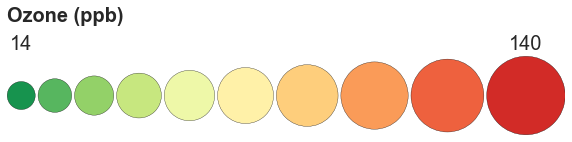

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

circle = plt.Circle((0, 0), radius=10, fc=colors[0])
plt.gca().add_patch(circle)

positions = [0]

position = 10
for i in range(1, 10):
    position += widths[i] + 2
    positions.append(position)
    circle = plt.Circle((position, 0), radius=widths[i], fc=colors[i])
    plt.gca().add_patch(circle)
    position += widths[i]

ax.set_yticks([])
ax.set_xticks([])
ax.grid(False)
ax.set_axis_bgcolor('w')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(0.5)

ax.text(positions[-1], widths[-1] + 5, "140", ha='center', fontsize=20)
ax.text(positions[0], widths[-1] + 5, "14", ha='center', fontsize=20)
ax.text(-10, widths[-1] + 25, "Ozone (ppb)", ha='left', weight='bold', fontsize=20)

plt.axis('scaled')
#plt.show()
plt.savefig("color_scale.png", dpi=200, bbox_inches='tight')